In [2]:
import numpy as np
import os
import sys

### Questions:

1) What axis to use in batchnorm argument? 


In [3]:
import tensorflow as tf
from tensorflow.python.ops import array_ops, math_ops      #for math operations division_no_nan
from tensorflow.keras.layers import *
from sklearn.metrics import roc_curve, auc
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

In [7]:
model = tf.keras.Sequential()

model.add(Conv2D(4, kernel_size=(3,3), input_shape=(20,12,1)))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))

model.add(Conv2D(8, kernel_size=(3,3)))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(24))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(BatchNormalization(axis=1))
model.add(Activation('sigmoid'))

model.build(input_shape=(120,72,1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 118, 70, 4)        40        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 59, 35, 4)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 59, 35, 4)         236       
_________________________________________________________________
activation_8 (Activation)    (None, 59, 35, 4)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 57, 33, 8)         296       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 16, 8)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 16, 8)        

In [37]:
push = lambda x: x > .5       #function to check if number greater than .5

def hls_model_accuracy(hls_model, test_X, test_y):                              #function for testing accurcry of hls model
    return accuracy_score(test_y, [push(i) for i in hls_model.predict(test_X)])

def get_timing(build_result):
    return (build_result['BestLatency'], build_result['WorstLatency'],
            build_result['IntervalMin'], build_result['IntervalMax'])


class CustomSensitivityAtSpecificity(tf.keras.metrics.SensitivityAtSpecificity):     #specificity TN/(TN+FP) 
                                                                                
    def __init__(self, specificity, num_thresholds=200, name=None, dtype=None):
        if specificity < 0 or specificity > 1:
            raise ValueError('`specificity` must be in the range [0, 1].')
        self.specificity = specificity
        self.num_thresholds = num_thresholds
        super().__init__(
            specificity, num_thresholds=num_thresholds, name=name, dtype=dtype)  #from the tf.kera.metrics.SensitivityAtSpecificity
                                                                                 #class, creates out object
    def result(self):
        specificities = math_ops.div_no_nan(
        self.true_negatives, self.true_negatives + self.false_positives)   #from keras class super()
        sensitivities = math_ops.div_no_nan(
        self.true_positives, self.true_positives + self.false_negatives)   
        return self._find_max_under_constraint(
                    specificities, sensitivities, math_ops.greater_equal)  #What?

    def get_threshold(self):
        specificities = math_ops.div_no_nan(
        self.true_negatives, self.true_negatives + self.false_positives)
        
        sensitivities = math_ops.div_no_nan(
        self.true_positives, self.true_positives + self.false_negatives)    #Sensitivity TP/(TP+FN)
        
        specs_above_thresh = array_ops.where(math_ops.greater_equal(specificities, self.value))   #What?
        
        return math_ops.reduce_min(array_ops.gather(self.thresholds, specs_above_thresh)).numpy()

def compiler(model_name):
    opt = tf.keras.optimizers.Adam(0.001)
    sensitivity_metric = tf.keras.metrics.SensitivityAtSpecificity(name='sens_at_spec',
                                                                             specificity=0.99925,     
                                                                             num_thresholds=20000)     
    auc_metric = tf.keras.metrics.AUC(name='auc', num_thresholds=200)   
    metrics = ['accuracy', sensitivity_metric, auc_metric]

    model_name.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)
    
    return model_name
       
def trainer(model_name, train_X, train_y):     

    model_name.fit(train_X, 
               train_y, 
               epochs=50, 
               verbose=1,
               batch_size=512, 
               validation_split=.2,   
               shuffle=True,
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                             patience=5,
                                                             restore_best_weights=True),     
                            pruning_callbacks.UpdatePruningStep()])

In [38]:
model = compiler(model)

In [39]:
model.load_weights('hist_models_original_size/try_1_copy_of_old_weights.h5')

In [40]:
test_X = np.load('/storage1/bz18310/hist_data/train_test_120x72/test_X.npy')
test_y = np.load('/storage1/bz18310/hist_data/train_test_120x72/test_y.npy')

## Testing the model versus coarser 20x12

In [48]:
coarse_model = tf.keras.models.load_model('./cnn_20x12_keras_trained')   #load trained model
compiler(coarse_model)

data = np.load('./data_hh4b_20x12_160000.npz')
test_X_c = data['test_X']
test_y_c = data['test_y']
data = 0


In [49]:
model.evaluate(test_X, test_y)
coarse_model.evaluate(test_X_c, test_y_c)

1250/1250 [==============================] - 5s 3ms/step - loss: 0.0757 - accuracy: 0.9739 - sens_at_spec: 0.6989 - auc: 0.9957


[0.07571113854646683,
 0.9738749861717224,
 0.698924720287323,
 0.9957337379455566]

In [52]:
def plot_roc_and_eff(model_list, model_name_list, test_X, test_y):
    bg_rate = 40*10**6
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots(figsize=(6,6))
    for i,m in enumerate(model_list):
        fpr, tpr, thresholds = roc_curve(test_y[i], m.predict(test_X[i]))
        
        rates, rates_errs, effs, effs_errs = eff_rate(fpr, tpr, thresholds, 
                                                      bg_rate, 
                                                      test_y[i], 
                                                      m.predict(test_X[i]))
        effs, rates, effs_errs, rates_errs = optimal_eff_rate(effs, rates, effs_errs, rates_errs)
        
        plot_roc(ax1, fpr, tpr, legend=True, label=model_name_list[i], lw=3.)
        plot_eff_rate(ax2, np.array(effs), np.array(rates), 
                      rates_errs=rates_errs, effs_errs=effs_errs, ls='', capsize=4., legend=True, label=model_name_list[i])
    
    ax1.plot([0,1], [0,1], ls='--', lw=2., color='black')
    ax1.set_yscale('log')
    ax1.set_ylim(0.000000001, 10)
    ax1.set_xscale('log')
    ax1.set_xlim(0.000000001, 10)
    
    ax2.set_xscale('log')
    ax2.set_xlim((1,1000))

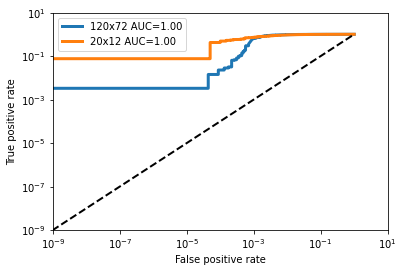

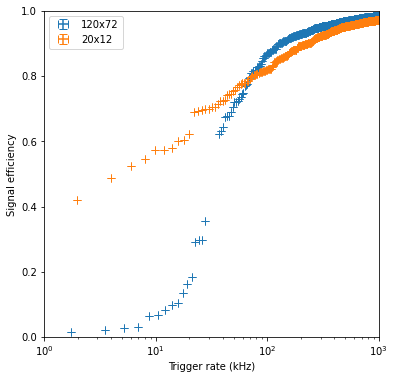

In [53]:
plot_roc_and_eff([model, coarse_model], ['120x72', '20x12'], [test_X, test_X_c], [test_y, test_y_c])

In [9]:
import hls4ml
from hls4ml.model.profiling import numerical, activations_keras, boxplot

sys.path.append('/usersc/bz18310/previous_notebook/cms-l1-triggers')

from utils.analysis import eff_rate, optimal_eff_rate
from utils.preprocessing import resize
from utils.plotting import *
from utils.hls4ml_helpers import *

In [30]:
def hls4ml_converter_quantized(model_name, converted_dir, stripping):   #not sure ill use this...
    
    if stripping:
        model_name = strip_pruning(model_name)
    
    hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']      #What does this do?
    hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
    hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

    config = hls4ml.utils.config_from_keras_model(model_name, granularity='name')   #hls4ml get config from kera config
    
    for l in config['LayerName']:
        config['LayerName'][l]['Strategy'] = 'Latency'
    config['LayerName']['sigmoid']['exp_table_t'] = 'ap_fixed<18,8>'
    config['LayerName']['sigmoid']['inv_table_t'] = 'ap_fixed<18,4>'

    display(config)
    hls_model = hls4ml.converters.convert_from_keras_model(model_name,
                                                       hls_config=config,   #set configuration of model
                                                       output_dir=converted_dir,  #6bit model save
                                                       fpga_part='xcku15p-ffva1760-2-e',     #What?
                                                        clock_period=(1/.24),      #set clock period??
                                                          io_type='io_stream')     #What?
    hls_model.compile()   #compiles model
    return hls_model

def hls4ml_converter(model_name, directory):
        
    config = hls4ml.utils.config_from_keras_model(model_name, granularity='model')
    print("-----------------------------------")
    config = {'Model': {'Precision': 'ap_fixed<5,1>',
              'ReuseFactor': 1,
              'Strategy': 'Latency'}}
    print("Configuration")
    display(config)
    print("-----------------------------------")
    hls_model = hls4ml.converters.convert_from_keras_model(model_name,
                                                           #hls_config=config,   #set configuration of model
                                                           output_dir=directory,  #6bit model save
                                                           fpga_part='xcku15p-ffva1760-2-e',     #What?
                                                            clock_period=(1/.24),      #set clock period??
                                                              io_type='io_stream')     #
    hls_model.compile()
    return hls_model

In [31]:
hls4ml_model = hls4ml_converter(model, 'hist_models_original_size/hls_try_1_copy_of_old/hls4ml_prj')

Interpreting Sequential
Topology:
Layer name: conv2d_6_input, layer type: Input
Layer name: conv2d_6, layer type: Conv2D
  -> Activation (linear), layer name: conv2d_6
Layer name: max_pooling2d_6, layer type: MaxPooling2D
Layer name: batch_normalization_12, layer type: BatchNormalization
Layer name: activation_12, layer type: Activation
Layer name: conv2d_7, layer type: Conv2D
  -> Activation (linear), layer name: conv2d_7
Layer name: max_pooling2d_7, layer type: MaxPooling2D
Layer name: batch_normalization_13, layer type: BatchNormalization
Layer name: activation_13, layer type: Activation
Layer name: dense_6, layer type: Dense
  -> Activation (linear), layer name: dense_6
Layer name: batch_normalization_14, layer type: BatchNormalization
Layer name: activation_14, layer type: Activation
Layer name: dense_7, layer type: Dense
  -> Activation (linear), layer name: dense_7
Layer name: batch_normalization_15, layer type: BatchNormalization
Layer name: activation_15, layer type: Activatio

{'Model': {'Precision': 'ap_fixed<5,1>',
  'ReuseFactor': 1,
  'Strategy': 'Latency'}}

-----------------------------------
Interpreting Sequential
Topology:
Layer name: conv2d_6_input, layer type: InputLayer, current shape: [[None, 120, 72, 1]]
Layer name: conv2d_6, layer type: Conv2D, current shape: [[None, 120, 72, 1]]
Layer name: max_pooling2d_6, layer type: MaxPooling2D, current shape: [[None, 118, 70, 4]]
Layer name: batch_normalization_12, layer type: BatchNormalization, current shape: [[None, 59, 35, 4]]
Layer name: activation_12, layer type: Activation, current shape: [[None, 59, 35, 4]]
Layer name: conv2d_7, layer type: Conv2D, current shape: [[None, 59, 35, 4]]
Layer name: max_pooling2d_7, layer type: MaxPooling2D, current shape: [[None, 57, 33, 8]]
Layer name: batch_normalization_13, layer type: BatchNormalization, current shape: [[None, 28, 16, 8]]
Layer name: activation_13, layer type: Activation, current shape: [[None, 28, 16, 8]]
Layer name: dense_6, layer type: Dense, current shape: [[None, 28, 16, 8]]
Layer name: batch_normalization_14, layer type: Batch

In [32]:
hls4ml_model.build(csim=False)

Synthesis report not found.


{}

In [33]:
hls4ml.report.read_vivado_report('hist_models_original_size/hls_try_1_copy_of_old/hls4ml_prj')

Found 1 solution(s) in hist_models_original_size/hls_try_1_copy_of_old/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
Synthesis report not found.
Co-simulation report not found.
